In [1]:
#dependencies
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from pptx import Presentation
import pptx.util
import imageio

In [2]:
input_folder = "./input"
intermediate_results = "./output"
output_file = "./my_slides.pptx"

In [3]:
SUPPORTED_FORMATS = (".BMP", ".DIB", ".JPEG", ".JPG", ".JPE", ".JP2", ".PNG", ".WEBP", ".PBM", ".PGM", ".PPM", ".SR", ".RAS", ".TIFF", ".TIF") #tuple
def isImage(filename):
    return filename.upper().endswith(SUPPORTED_FORMATS)

In [4]:
#make ordered list of image files files in input folder
only_files = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]
only_files.sort()
only_images = list(filter(lambda x: isImage(x), only_files))
only_images

['IMG_8499.JPG',
 'IMG_8500.JPG',
 'IMG_8501.JPG',
 'IMG_8502.JPG',
 'IMG_8503.JPG',
 'IMG_8504.JPG',
 'IMG_8505.JPG',
 'IMG_8506.JPG',
 'IMG_8507.JPG',
 'IMG_8508.JPG',
 'IMG_8509.JPG',
 'IMG_8510.JPG',
 'IMG_8511.JPG',
 'IMG_8512.JPG',
 'IMG_8513.JPG',
 'IMG_8514.JPG',
 'IMG_8515.JPG',
 'IMG_8516.JPG',
 'IMG_8517.JPG']

In [22]:
bw_crop_images = []
colour_images = []
kps = []
des = []
orb = cv2.ORB_create()

for image in only_images:
    relative_path = input_folder + "/" + image
    print("processing: " + relative_path)
    img = cv2.imread(relative_path,0)
    img_colour = cv2.imread(relative_path)
    img = cv2.resize(img, (0,0) ,fx=0.1, fy=0.1)
    kp = orb.detect(img,None)
    kp, one_des = orb.compute(img, kp)
    kps.append(kp)
    des.append(one_des)
    bw_crop_images.append(img)
    colour_images.append(img_colour)
    
print("images: " + str(len(bw_crop_images)))
print("color images: " + str(len(colour_images)))
print("keypoints: " + str(len(kps)))
print("descriptors: " +  str(len(des)))

processing: ./input/IMG_8499.JPG
processing: ./input/IMG_8500.JPG
processing: ./input/IMG_8501.JPG
processing: ./input/IMG_8502.JPG
processing: ./input/IMG_8503.JPG
processing: ./input/IMG_8504.JPG
processing: ./input/IMG_8505.JPG
processing: ./input/IMG_8506.JPG
processing: ./input/IMG_8507.JPG
processing: ./input/IMG_8508.JPG
processing: ./input/IMG_8509.JPG
processing: ./input/IMG_8510.JPG
processing: ./input/IMG_8511.JPG
processing: ./input/IMG_8512.JPG
processing: ./input/IMG_8513.JPG
processing: ./input/IMG_8514.JPG
processing: ./input/IMG_8515.JPG
processing: ./input/IMG_8516.JPG
processing: ./input/IMG_8517.JPG
images: 19
color images: 19
keypoints: 19
descriptors: 19


In [78]:
def getPoints(img):
    h2,w2 = img.shape[:2]
    return np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    
def rotateTarget(target_pts, H):
    return cv2.perspectiveTransform(target_pts, H)

def translateAndRotateTargetToSource(source_img, target_img, H):
    source_pts = getPoints(source_img)
    target_pts = rotateTarget(getPoints(target_img), H)
    points = np.concatenate((source_pts, target_pts), axis=0)
    [xmin, ymin] = np.int32(points.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(points.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    return cv2.warpPerspective(target_img, Ht.dot(H), (xmax-xmin, ymax-ymin))

def replacePixelsSourceWithTarget(source_img, target_img):
    h1,w1 = source_img.shape[:2]
    h2,w2 = target_img.shape[:2]
    source_pts = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    target_pts = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts = np.concatenate((source_pts, target_pts), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    joined = np.zeros((ymax-ymin, xmax-xmin))
    #print("joined")
    #print(joined.shape)
    #print("source_img")
    #print(source_img.shape)
    #print("source_hole")
    #print(joined[t[1]:h1+t[1],t[0]:w1+t[0]].shape)
    #print("target")
    #print(target_img.shape)
    #print("target_hole")
    #print(joined[:h2, :w2].shape)
    joined[t[1]:h1+t[1],t[0]:w1+t[0]] = source_img
    joined[:h2, :w2] = target_img
    #plt.imshow(joined),plt.show()
    return joined

1
to process


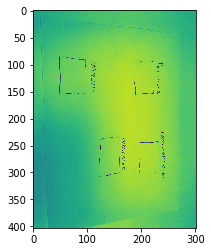

processed


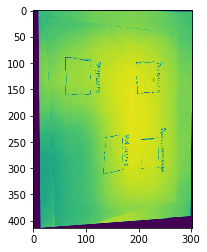

blob before


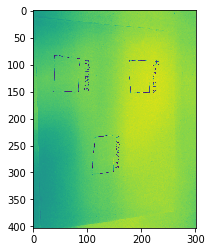

blob after


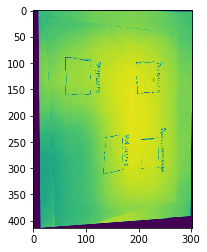

2
to process


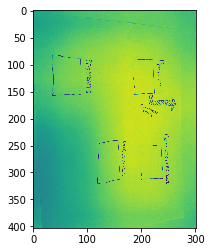

processed


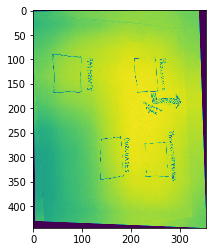

blob before


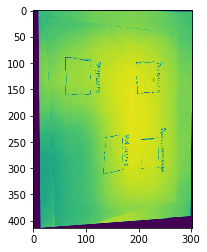

blob after


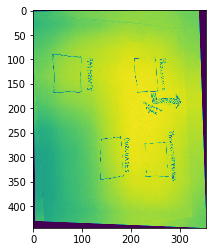

3
to process


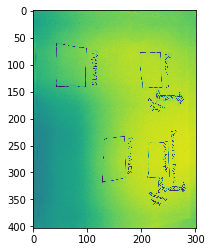

processed


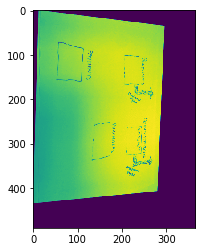

blob before


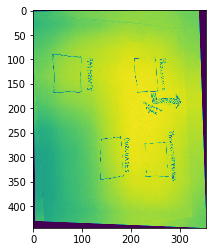

blob after


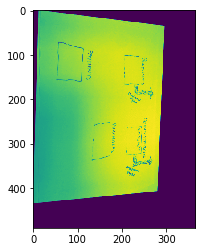

4
to process


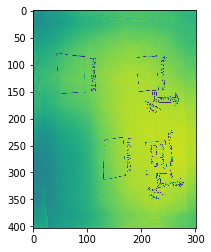

processed


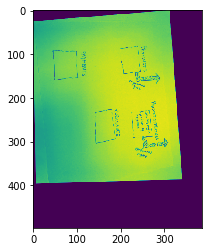

blob before


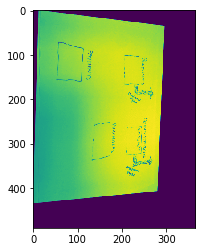

blob after


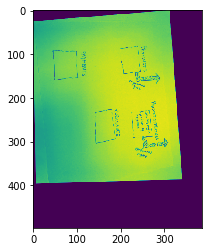

5
to process


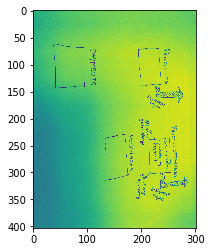

processed


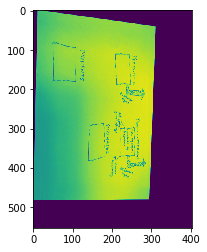

blob before


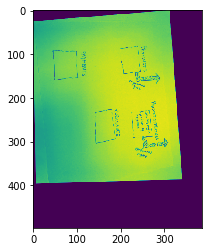

blob after


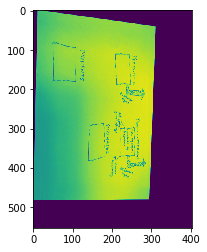

6
to process


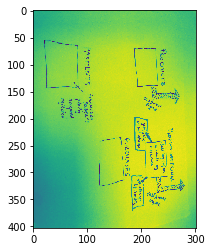

processed


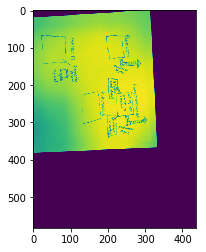

blob before


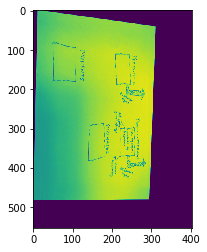

blob after


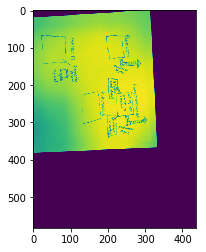

7
to process


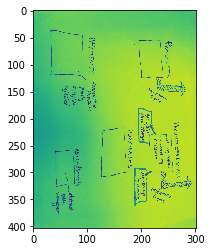

processed


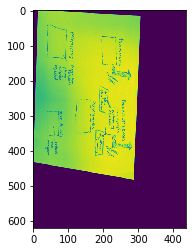

blob before


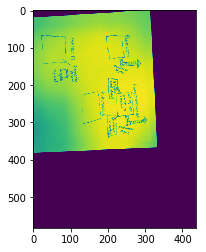

blob after


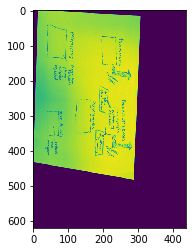

8
to process


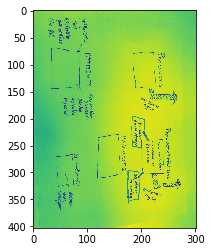

processed


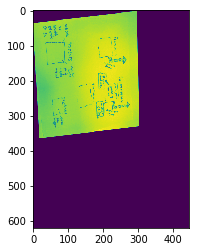

blob before


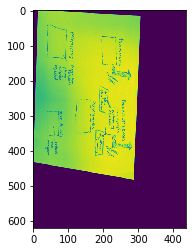

blob after


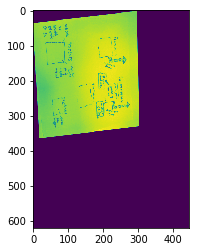

9
to process


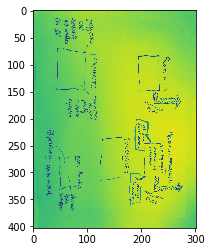

processed


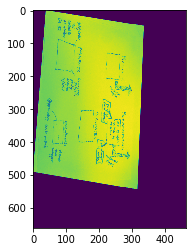

blob before


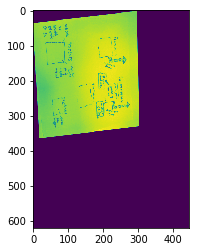

blob after


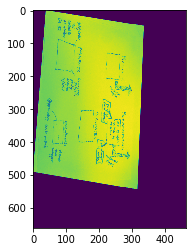

10
to process


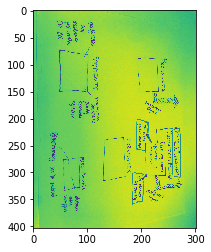

processed


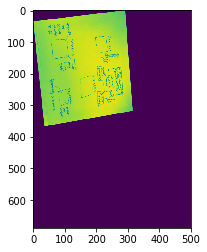

blob before


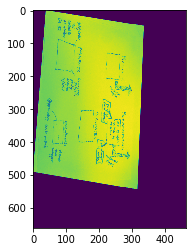

blob after


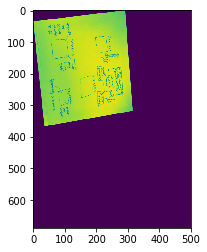

11
to process


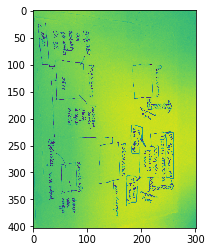

processed


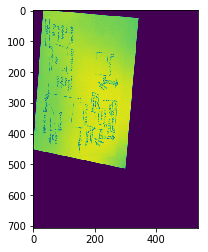

blob before


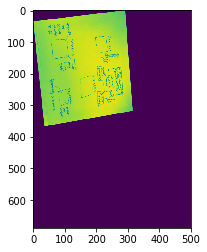

blob after


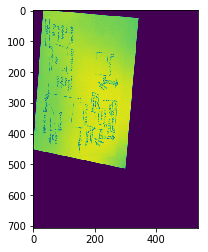

12
to process


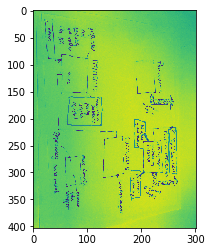

processed


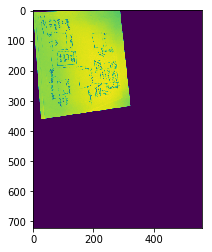

blob before


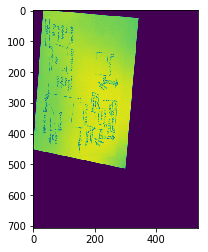

blob after


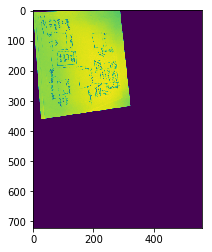

13
to process


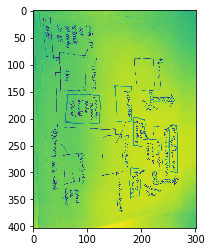

processed


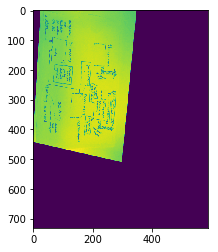

blob before


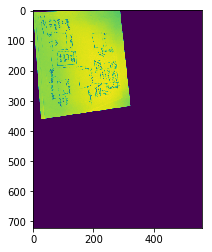

blob after


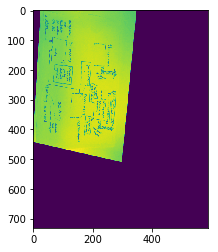

14
to process


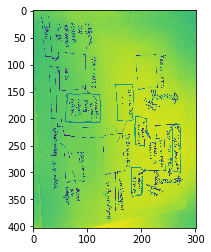

processed


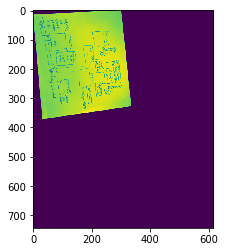

blob before


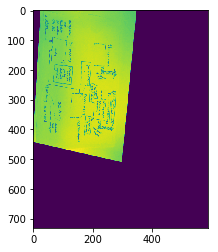

blob after


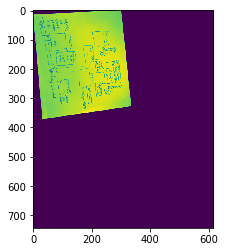

15
to process


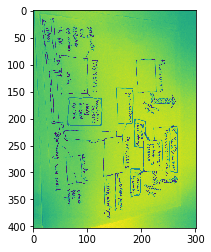

processed


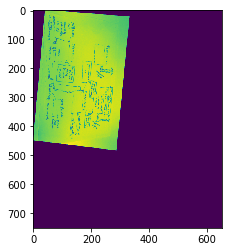

blob before


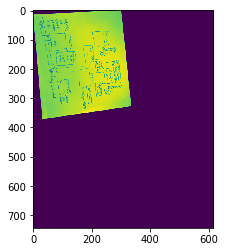

blob after


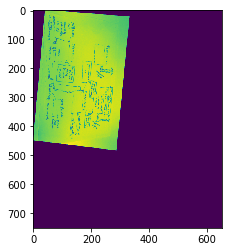

16
to process


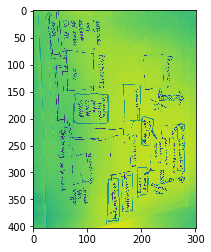

processed


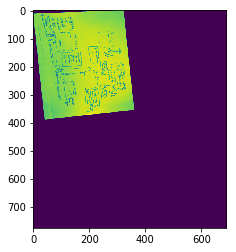

blob before


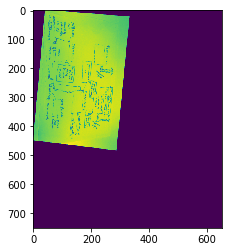

blob after


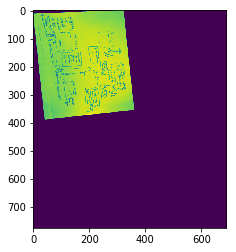

17
to process


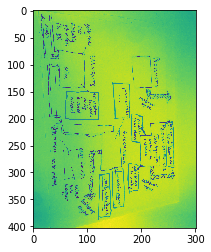

processed


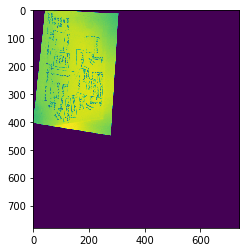

blob before


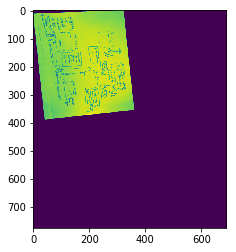

blob after


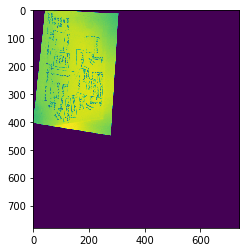

18
to process


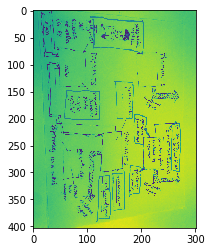

processed


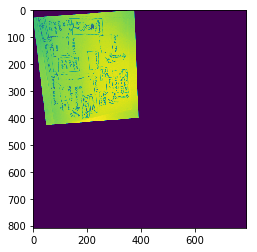

blob before


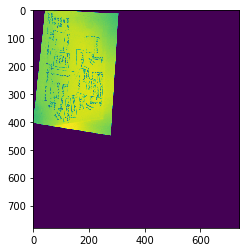

blob after


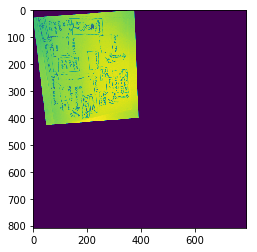

In [79]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
image_blob = bw_crop_images[0]
homography_vector = []
for idx in range(1, len(bw_crop_images)):
    print(idx)
    print("to process")
    plt.imshow(bw_crop_images[idx]),plt.show()

    blob_kp = orb.detect(image_blob,None)
    blob_kp, blob_des = orb.compute(image_blob, blob_kp)
    
    idx_kp = orb.detect(bw_crop_images[idx],None)
    idx_kp, idx_des = orb.compute(bw_crop_images[idx], idx_kp)

    matches = bf.match(blob_des, idx_des)
    matches = sorted(matches, key = lambda x:x.distance)
    
    src_pts = np.array([blob_kp[mat.queryIdx].pt for mat in matches])
    dst_pts =  np.array([idx_kp[mat.trainIdx].pt for mat in matches])
    H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)[0]
    rotatedTranslated = translateAndRotateTargetToSource(image_blob, bw_crop_images[idx], H)
    print("processed")
    plt.imshow(rotatedTranslated),plt.show()
    print("blob before")
    plt.imshow(image_blob),plt.show()
    image_blob = replacePixelsSourceWithTarget(image_blob, rotatedTranslated).astype('uint8')
    print("blob after")
    plt.imshow(image_blob),plt.show()


In [ ]:
M_tot = np.eye(3)
results = []
for idx, matches in enumerate(matches_array):
    print(idx)
    src_pts = np.array([kps[idx][mat.queryIdx].pt for mat in matches])
    dst_pts =  np.array([kps[idx+1][mat.trainIdx].pt for mat in matches])
    M, mask = cv2.findHomography(src_pts,dst_pts, cv2.RANSAC,5.0)
    print(M.shape)
    M_tot = M_tot.dot(M)
    result = warpTwoImages(colour_images[idx], colour_images[idx+1], M_tot)
    print(result.shape)
    cv2.imwrite(intermediate_results + "/" + only_images[idx+1] , result)
    results.append(result)
    plt.imshow(result),plt.show()

In [ ]:
##TODO. Copy first frame!

In [ ]:
#strech each image to a new slide. Proportions of slide will be keept.
prs = Presentation()
BLANK_SLIDE = prs.slide_layouts[6]
# default slide width
#prs.slide_width = 9144000
# slide height @ 4:3
#prs.slide_height = 6858000
# slide height @ 16:9
#prs.slide_height = 5143500
slideAspectRatio = prs.slide_width/prs.slide_height
for image in only_images:
    relative_path = intermediate_results + "/" + image
    slide = prs.slides.add_slide(BLANK_SLIDE)
    shapes = slide.shapes
    picture = shapes.add_picture(relative_path, 0, 0, prs.slide_width, prs.slide_height)
    
prs.save(output_file)